In [29]:
import torch.nn as nn
import os
import torch.nn.functional as F
from collections import Counter
from torchvision import transforms, datasets
import torchvision
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from helper import set_deterministic, set_device, build_dataloaders_cifar, train_model, evaluate_model
from tqdm import tqdm 

import time
from torchinfo import summary

# 1. Set Seed, Determinism & Device

In [2]:
device = set_device()

PyTorch version: 2.2.2
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [3]:
set_deterministic()

Set deterministic behavior


In [34]:
BATCH_SIZE = 128
NUM_EPOCHS = 5
LEARNING_RATE = 0.01
NUM_WORKERS = 10
RANDOM_SEED = 42

#set_seed(RANDOM_SEED)

# 2. Manual Transforms

In [33]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [35]:
train_dataloader, test_dataloader, test_dataset_viz, class_names = build_dataloaders_cifar(
                                                                            data_path= '../../data',
                                                                            train_transforms=train_transforms,
                                                                            test_transforms=test_transforms,
                                                                            batch_size=BATCH_SIZE,
                                                                            num_workers=NUM_WORKERS) 

len(train_dataloader), len(test_dataloader)               

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


(391, 79)

In [36]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# 3. AlexNet Pytorch Model

In [8]:
class PyTorchModel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        logits = self.classifier(x)
        return logits

In [37]:
pytorch_model = PyTorchModel(num_classes=len(class_names))

summary(pytorch_model, (1, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "kernel_size", "trainable"],
        col_width=16,
        row_settings=['var_names']) 


Layer (type (var_name))                  Input Shape      Output Shape     Param #          Kernel Shape     Trainable
PyTorchModel (PyTorchModel)              [1, 3, 224, 224] [1, 10]          --               --               True
├─Sequential (features)                  [1, 3, 224, 224] [1, 256, 6, 6]   --               --               True
│    └─Conv2d (0)                        [1, 3, 224, 224] [1, 64, 55, 55]  23,296           [11, 11]         True
│    └─ReLU (1)                          [1, 64, 55, 55]  [1, 64, 55, 55]  --               --               --
│    └─MaxPool2d (2)                     [1, 64, 55, 55]  [1, 64, 27, 27]  --               3                --
│    └─Conv2d (3)                        [1, 64, 27, 27]  [1, 192, 27, 27] 307,392          [5, 5]           True
│    └─ReLU (4)                          [1, 192, 27, 27] [1, 192, 27, 27] --               --               --
│    └─MaxPool2d (5)                     [1, 192, 27, 27] [1, 192, 13, 13] --            

# 4. Train Model

In [38]:
def train_1(model, train_dataloader, test_dataloader, epochs, criterion, optimizer, device, scheduler = None):
    """
    This function trains the model
    
    Parameters
    ----------
    model: nn.Module
    train_dataloader: DataLoader
    test_dataloader: DataLoader
    epochs: int
    criterion: nn.Module
    optimizer: nn.Module
    device: str
    """
    
    model.to(device)
    
    results = {"train_loss_per_batch": [],
               "train_loss_per_epoch": [],
               "train_acc_per_epoch": [], 
               "val_loss_per_epoch": [], 
               "val_acc_per_epoch": []}
    
    for epoch in tqdm(range(epochs)):
        model.train()
        training_loss, training_acc = 0.0, 0.0
        
        for batch, (inputs, labels) in enumerate(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            results['train_loss_per_batch'].append(loss.item())
            training_loss += loss.item()
            training_acc += (outputs.argmax(1) == labels).float().mean()
            training_acc = training_acc.item()
            
        scheduler.step()
        epoch_loss_tr = training_loss / len(train_dataloader)
        epoch_acc_tr = training_acc / len(train_dataloader)
        
        print(f'Epoch: {epoch} Training Loss: {epoch_loss_tr}, Training Accuracy: {epoch_acc_tr}')
        
        model.eval()
        test_loss, test_acc = 0.0, 0.0
        
        for batch, (inputs, labels) in enumerate(test_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            test_acc += (outputs.argmax(1) == labels).float().mean()
            test_acc = test_acc.item()
            
        epoch_loss_te = test_loss / len(test_dataloader)
        epoch_acc_te = test_acc / len(test_dataloader)
        
        print(f'Epoch: {epoch} Validation Loss: {epoch_loss_te}, Validation Accuracy: {epoch_acc_te}')
    
        results['train_loss_per_epoch'].append(epoch_loss_tr)
        results['train_acc_per_epoch'].append(epoch_acc_tr)
        results['val_loss_per_epoch'].append(epoch_loss_te)
        results['val_acc_per_epoch'].append(epoch_acc_te)
        
    return model, results


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(pytorch_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

pytorch_model, results = train_1(model= pytorch_model,
                                     criterion= criterion,
                                     optimizer= optimizer,
                                     scheduler= scheduler,
                                     train_dataloader= train_dataloader,
                                     test_dataloader= test_dataloader,
                                     epochs= NUM_EPOCHS,
                                     device= device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 Training Loss: 13657.297491001656, Training Accuracy: 0.0989090512170816


 20%|██        | 1/5 [01:29<05:59, 89.92s/it]

Epoch: 0 Validation Loss: 2.303139303303972, Validation Accuracy: 0.10096914556962025
Epoch: 1 Training Loss: 2.303174138374036, Training Accuracy: 0.10030770850608416


 40%|████      | 2/5 [02:21<03:22, 67.65s/it]

Epoch: 1 Validation Loss: 2.302990699116188, Validation Accuracy: 0.10027689873417721
Epoch: 2 Training Loss: 2.3032611337159294, Training Accuracy: 0.09912484015345269


 60%|██████    | 3/5 [03:14<02:01, 60.95s/it]

Epoch: 2 Validation Loss: 2.303204119959964, Validation Accuracy: 0.10096914556962025
Epoch: 3 Training Loss: 2.3032946501241622, Training Accuracy: 0.09696291169851942


 80%|████████  | 4/5 [04:07<00:57, 57.69s/it]

Epoch: 3 Validation Loss: 2.3032077867773513, Validation Accuracy: 0.09889240506329114
Epoch: 4 Training Loss: 2.303276875439812, Training Accuracy: 0.10013587151646919


100%|██████████| 5/5 [05:04<00:00, 60.86s/it]

Epoch: 4 Validation Loss: 2.30383529240572, Validation Accuracy: 0.09958465189873418


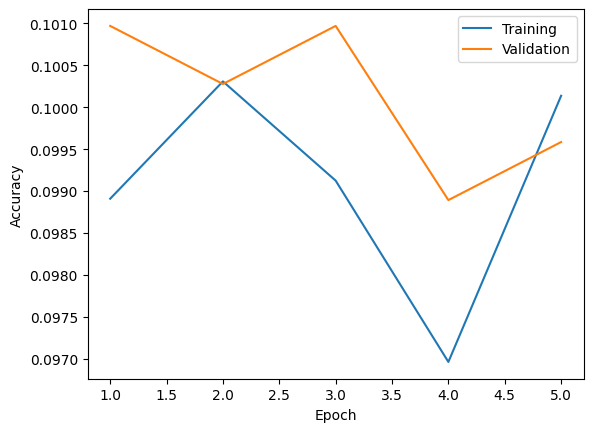

In [40]:
plt.plot(np.arange(1, NUM_EPOCHS+1), results['train_acc_per_epoch'], label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), results['val_acc_per_epoch'], label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()